In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import math

import wandb
from tqdm.notebook import tqdm_notebook as tqdm

from dataclasses import dataclass

from src.linreg import LinregDataset
from src.utils import save, set_seed
from src.training import train, evaluate
from src.transformer import Transformer

In [2]:
@dataclass
class Config:
    n_dims:       int = 4
    num_layers:   int = 1
    attn_heads:   int | None = None
    head_dim:     int | None = None
    hidden_dim:   int | None = None
    dhat:         int | None = None
    mlp_hidden:   int = 128
    context:      int = 129
    method:       str = 'softmax'
    activation:   nn.Module = nn.GELU
    elu_alpha:    float = 1.0
    
    def _calculate_dhat(self):
        if self.method in ['based', 'rebased']:
            low = math.floor(math.sqrt(self.head_dim))
            top = math.ceil(math.sqrt(self.head_dim))
            lowdiff = math.fabs(self.hidden_dim - low ** 2 * self.attn_heads)
            topdiff = math.fabs(self.hidden_dim - top ** 2 * self.attn_heads)
            if lowdiff < topdiff:
                dhat = low * self.attn_heads
            else:
                dhat = top * self.attn_heads
        else:
            dhat = self.hidden_dim
        return dhat
    
    def __post_init__(self):
        if self.hidden_dim is not None and self.attn_heads is not None:
            self.head_dim = self.hidden_dim // self.attn_heads
        elif self.attn_heads is not None and self.head_dim is not None:
            self.hidden_dim = self.attn_heads * self.head_dim
        else:
            raise ValueError('You should provide either (hidden_dim, attn_heads) or (attn_heads, head_dim).')
        
        if self.dhat is None:
            self.dhat = self._calculate_dhat()
    
def get_config(name, n_dims):
    models = {
        'softmax': (Config(
            n_dims = n_dims, num_layers = 2,
            attn_heads = 4, hidden_dim = 96,
            mlp_hidden = 256, context = 257,
            method = 'softmax',
        ), 1e-3, 64, 32),
        'based': (Config(
            n_dims = n_dims, num_layers = 2,
            attn_heads = 4, hidden_dim = 96 + 16,
            mlp_hidden = 256, context = 257,
            method = 'based'
        ), 1e-3, 64, 32),
        'rebased': (Config(
            n_dims = n_dims, num_layers = 2,
            attn_heads = 4, hidden_dim = 96 + 16,
            mlp_hidden = 256, context = 257,
            method = 'rebased'
        ), 1e-3, 64, 32),
        'learnable': (Config(
            n_dims = n_dims, num_layers = 2,
            attn_heads = 4, hidden_dim = 96,
            mlp_hidden = 256, context = 257,
            method = 'learnable'
        ), 1e-3, 64, 32),
        'elu': (Config(
            n_dims = n_dims, num_layers = 2,
            attn_heads = 4, hidden_dim = 96,
            mlp_hidden = 256, context = 257,
            method = 'elu'
        ), 1e-3, 64, 32),
        'squared': (Config(
            n_dims = n_dims, num_layers = 2,
            attn_heads = 4, hidden_dim = 96,
            mlp_hidden = 256, context = 257,
            method = 'squared'
        ), 1e-3, 64, 32),
    }
    return models[name]

## Тренировка

In [3]:
sum([p.numel() for p in Transformer(get_config('softmax', 8)[0]).parameters()])

200584

In [4]:
sum([p.numel() for p in Transformer(get_config('based', 8)[0]).parameters()])

206680

In [5]:
sum([p.numel() for p in Transformer(get_config('rebased', 8)[0]).parameters()])

206720

In [6]:
sum([p.numel() for p in Transformer(get_config('learnable', 8)[0]).parameters()])

205384

In [7]:
sum([p.numel() for p in Transformer(get_config('elu', 8)[0]).parameters()])

200584

In [8]:
sum([p.numel() for p in Transformer(get_config('squared', 8)[0]).parameters()])

200776

гипотеза: лосс пропорционален дисперсии иксов

In [ ]:
from torch.optim import AdamW
from itertools import product

N = 64
n_dims = 4
mean, std = 0, 2

seeds = [42, 451, 1984]
models = ['softmax', 'based', 'rebased', 'learnable', 'elu', 'squared']
bs = [1, 5]

runs = []
for model, bs, seed in product(models, bs, seeds):
    runs.append((model, bs, seed))

device = 'cuda' if torch.cuda.is_available() else 'cpu'

extrp_bs = [1, 5, 10, 15, 20]

for (name, b, seed) in runs:

    config, lr, train_bsize, test_bsize = get_config(name, n_dims)
    if config.context != N * 2 + 1:
        config.context = N * 2 + 1

    train_loader = DataLoader(LinregDataset(
        n_dims = n_dims, n_points = N + 1,
        xmean = mean, xstd = std, device = device
    ), batch_size = train_bsize)
    test_loader = DataLoader(LinregDataset(
        n_dims = n_dims, n_points = N + 1,
        xmean = mean, xstd = std, device = device,
        total = test_bsize * 15
    ), batch_size = test_bsize)

    set_seed(seed)

    model = Transformer(config).to(device)
    optimizer = AdamW(model.parameters(), lr=lr)

    run_name = f'{name}_{b}_{seed}'
    run = wandb.init(
        project = 'Linear Transformer',
        name = run_name,
        config = {
            'name': f'{name}_{b}',
            'model': name,
            'b': b,
            'train batch size': train_bsize,
            'test batch size': test_bsize,
            'lr': lr,
            'seed': seed,
            'N': N,
        }
    )

    loss_history, eval_history = train(
        model, train_loader, test_loader, optimizer, 
        steps = 5000, b = b, run = run, log_every = 50
    )

    extrapolation = []
    for bi in extrp_bs:
        result = evaluate(test_loader, model, bi)
        extrapolation.append(result)
        print(f'b = {bi} --- loss = {result:.5f}')
        run.log({'b': bi, 'MSE': result})
    
    run.finish()

    save(
        name = run_name, 
        model = model,
        loss = loss_history, 
        eval = eval_history, 
        extr = extrapolation,
        path = './results/'
    )

    torch.cuda.empty_cache()

## Валидация

In [ ]:
import json
from itertools import product

seeds = [42, 451, 1984]
models = ['softmax', 'based', 'rebased', 'learnable', 'elu', 'squared']
bs = [1, 5]

device = 'cuda'

runs = []
for model, b in product(models, bs):
    runs.append((model, b))
    
test_seed = 4815163242 % 2**16
num_launches = 100
    
results = {}
pbar = tqdm(range(len(runs) * num_launches * len(seeds)))
for (name, b) in runs:
    config, lr, train_bsize, test_bsize = get_config(name, n_dims)
    if config.context != N * 2 + 1:
        config.context = N * 2 + 1
    
    res = []
    
    set_seed(test_seed)
    for seed in seeds:
        model = torch.load(f'./results/models/{name}_{b}_{seed}.pt')
            
        for i in range(num_launches):
            
            std = torch.rand((1,)).item() * 2
            loader = DataLoader(LinregDataset(
                n_dims = n_dims, n_points = N + 1,
                xmean = mean, xstd = std, device = device,
                total = test_bsize * 15, 
            ), batch_size = test_bsize)
            
            total = 0
            with torch.no_grad():
                for (x, y) in loader:
                    
                    preds = model(x[:, :-1], b)
                    preds = torch.stack(preds)
                    targs = torch.stack([y] * b)
                    
                    loss = (targs[:,:,-1] - preds[:,:,-1]).square().mean(dim=0).mean()
                    
                    total += loss.item() / loader.dataset.n_dims
            res.append(total / len(loader))
            pbar.set_description(f'Run \'{name}_{b}\', seed {seed}...')
            pbar.update(1)
                
    results[f'{name}_{b}'] = res
    
with open('./results/data/evaluation.json', 'w') as f:
    f.write(json.dumps(results, indent=4))

In [3]:
import os
import json

import numpy as np 

import matplotlib as mpl
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'grid'])
mpl.rcParams["font.size"] = "16"

In [4]:
with open('./results/data/evaluation.json', 'r') as f:
    results = json.loads(f.read())
    
models = results.keys()

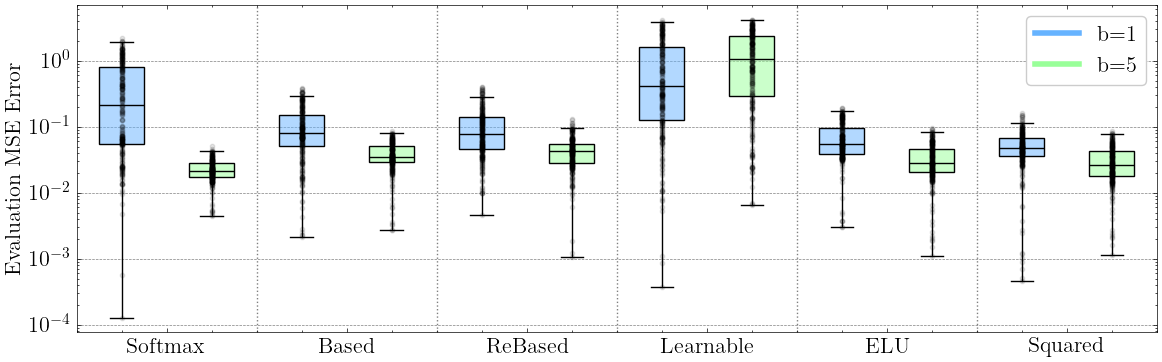

In [5]:
# Prepare data for boxplot
boxplot_data = []
labels = []

models = ['softmax', 'based', 'rebased', 'learnable', 'elu', 'squared'][::-1]
bs = [1, 5][::-1]

for model in models:
    for b in bs:
        key = f"{model}_{b}"
        boxplot_data.append(results[key])
        labels.append(key)
boxplot_data = boxplot_data[::-1]

# Create the boxplot
plt.figure(figsize=(12, 4))
box = plt.boxplot(boxplot_data, patch_artist=True, notch=False, vert=True, zorder=1, showfliers=False)

# Define colors for the boxplots
colors = ['#99FF99', '#66B3FF'][::-1]
for i, patch in enumerate(box['boxes']):
    model_index = i // len(bs)  # Determine the model index
    # patch.set_alpha(0.5)
    patch.set_edgecolor('black')
    patch.set_facecolor(colors[i % len(colors)])  # Set color based on hyperparameter
    
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.5))
    
    data = boxplot_data[i]
    y = np.random.normal(i + 1, 0.0, size=len(data))
    plt.scatter(y, data, alpha = 0.1, color = 'black', s = 10, zorder = 2)
    
for median in box['medians']:
    median.set_color('black')

# Adding legend
handles = [plt.Line2D([0], [0], color=colors[i], lw=4) for i in range(len(bs))]#[::-1]
labels_legend = [f'b={b}' for b in [1, 5, 10, 15]]
plt.legend(handles, labels_legend, loc='upper right', ncol=1)

# Set x-ticks and labels
plt.xticks(
    [1.5 + 2 * i for i in range(0, len(models))], 
    ['Softmax', 'Based', 'ReBased', 'Learnable', 'ELU', 'Squared'], rotation = 0)
plt.ylabel('Evaluation MSE Error')
plt.grid(False, axis='x')
plt.grid(True, axis='y', which='major')

plt.axvline(2.5, 0, alpha = 0.5, color = 'black', linestyle = ':')
plt.axvline(4.5, 0, alpha = 0.5, color = 'black', linestyle = ':')
plt.axvline(6.5, 0, alpha = 0.5, color = 'black', linestyle = ':')
plt.axvline(8.5, 0, alpha = 0.5, color = 'black', linestyle = ':')
plt.axvline(10.5,0, alpha = 0.5, color = 'black', linestyle = ':')

plt.yscale('log')

# Show the plot
plt.tight_layout()
plt.savefig('./performance 1.svg')
plt.show()

In [6]:
def load_data(run_name):
    with open(f'./results/data/{run_name}.json', 'r') as file:
        result = json.loads(file.read())
    return result

def get_plotting_data(key, *names):
    result = []
    for name in names:
        result.append(load_data(name)[key])
    result = np.array(result)
    
    mean = result.mean(axis=0)
    var = result.std(axis=0)
    
    return mean, var

In [8]:
seeds = [42, 451, 1984]

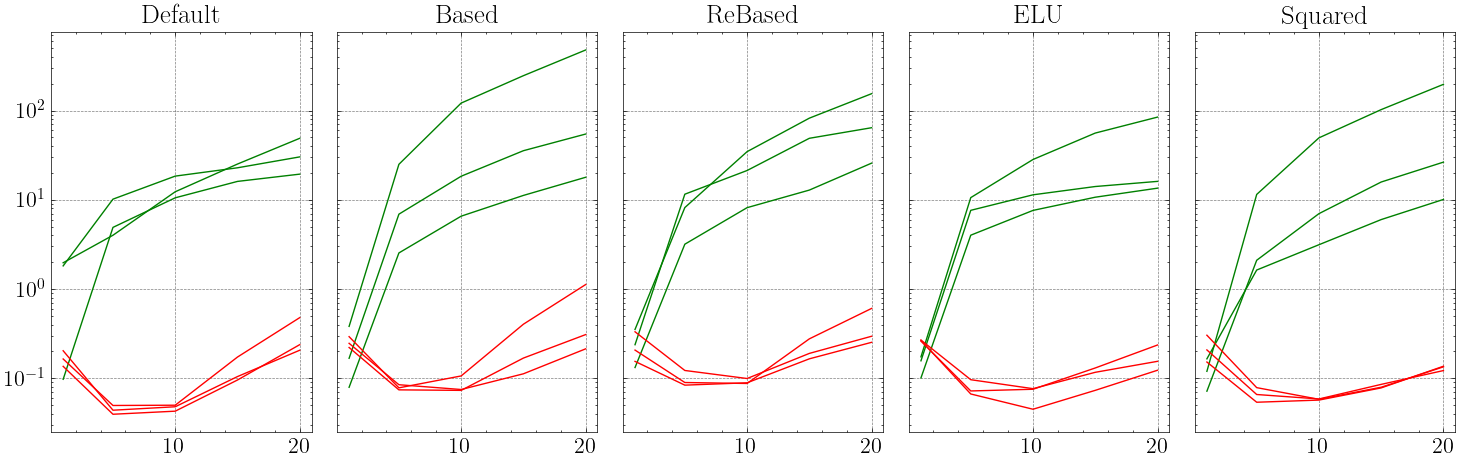

In [11]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5), sharey='row')

x = [1, 5, 10, 15, 20]
bs = [1, 5]
colors = ['green', 'red']

for i, name in enumerate(['softmax', 'based', 'rebased', 'elu', 'squared']):
    for color, b in zip(colors, bs):
        for seed in seeds:
            data = load_data(f'{name}_{b}_{seed}')['extr']
            axs[i].plot(x, data, color = color)
        axs[i].set_yscale('log')

axs[0].title.set_text('Default')
axs[1].title.set_text('Based')
axs[2].title.set_text('ReBased')
# axs[3].title.set_text('Learnable')
axs[3].title.set_text('ELU')
axs[4].title.set_text('Squared')

plt.tight_layout()
plt.savefig('./extrapolation 1.svg')
plt.show()

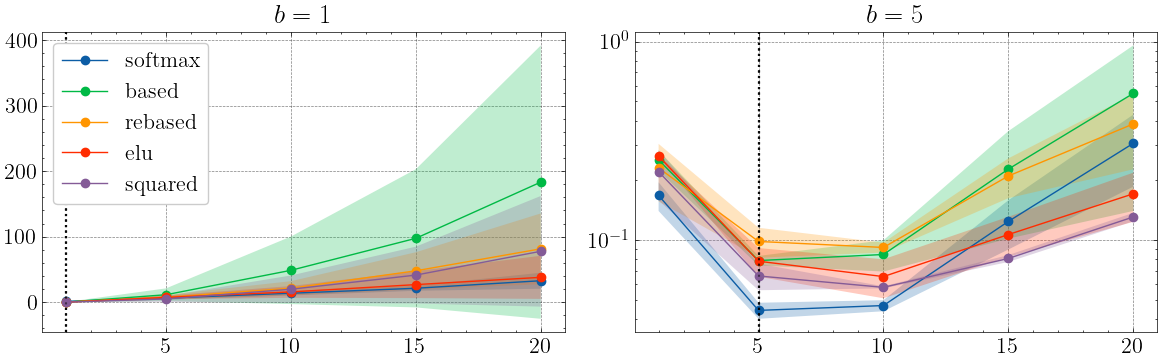

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

x = [1, 5, 10, 15, 20]
names = ['softmax', 'based', 'rebased', 'elu', 'squared']

for i in range(2):
    for name in names:
        nms = [f'{name}_{x[i]}' + f'_{seed}' for seed in [42, 451, 1984]]
        mean, var = get_plotting_data('extr', *nms)
        axs[i].plot(x, mean, label = name, marker = 'o')
        axs[i].fill_between(x, mean + var, mean - var, alpha = 0.25, linewidth = 0)
        axs[i].axvline(x=x[i], color = 'k', linestyle = ':', alpha = 0.5, linewidth = 1.5)
axs[1].set_yscale('log')
    
axs[0].legend(loc='upper left')
axs[0].title.set_text(r'$b = 1$')
axs[1].title.set_text(r'$b = 5$')
# axs[2].title.set_text(r'$b = 10$')
# axs[3].title.set_text(r'$b = 15$')

plt.tight_layout()
plt.savefig('./extrapolation 2.svg', format = 'svg')
plt.show()